In [134]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.multiprocessing as mp
import wandb
import imageio
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from sklearn.model_selection import train_test_split
import os

In [135]:
DATASET_PATH = '/home/bk_anupam/code/ML/DeepLearningWSL/AutoEncoders/data/lfw-deepfunneled/'
ATTRIBUTES_PATH = '/home/bk_anupam/code/ML/DeepLearningWSL/AutoEncoders/data/'
class Config:
    RUNTIME = "LOCAL"
    SUBSET_FRACTION = None
    NUM_EPOCHS = 30
    BATCH_SIZE = 64
    PRECISION = "16-mixed"
    LOG_EVERY_N_STEPS = 10
    INPUT_IMAGE_SIZE = (64, 64)
    TRAIN_IMG_MEAN = [0.485, 0.456, 0.406]
    TRAIN_IMG_STD = [0.229, 0.224, 0.225]
    NUM_WORKERS = mp.cpu_count()
    EARLY_STOPPING_PATIENCE = 6  # Add this line for early stopping patience
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on', Config.DEVICE)

Training on cuda


In [136]:
class SchedulerConfig:
    # for ReduceLROnPlateau (number of epochs with no improvement after which the learning rate will be reduced)
    SCHEDULER_PATIENCE = 5  
    # for ReduceLROnPlateau (factor by which the learning rate will be reduced)
    FACTOR = 0.5 
    SCHEDULER = "ReduceLROnPlateau"
    T_0 = 10 # for CosineAnnealingWarmRestarts (Number of epochs before the first restart)
    MIN_LR = 5e-7 # for CosineAnnealingWarmRestarts (Minimum learning rate)
    T_mult = 1 # for CosineAnnealingWarmRestarts (Factor by which Ti(number of epochs between two restarts) increases)
    MAX_LR = 1e-3 # for CosineAnnealing (Initial learning rate)
    STEPS_PER_EPOCH = 13 # for OneCycleLR
    STEP_SIZE = 10 # for StepLR
    GAMMA = 0.5 # for StepLR

In [137]:
class WandbConfig:
    WANDB_KEY = ""
    WANDB_RUN_NAME = "test_run"
    WANDB_PROJECT = "simple_autoencoder"
    USE_WANDB = False    

In [138]:
if Config.RUNTIME == "KAGGLE":
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    WANDB_KEY = user_secrets.get_secret("wandb")
    DATASET_PATH = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

if WandbConfig.USE_WANDB:
    # Log in to W&B
    os.environ["WANDB_API_KEY"] = WANDB_KEY
    # Initialize W&B
    wandb.init(project=WandbConfig.WANDB_PROJECT, name=WandbConfig.WANDB_RUN_NAME)

In [139]:
img_df = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    img_df.append({"person":person, "path": path})
    
img_df = pd.DataFrame(img_df)
#too much Bush
img_df = img_df.groupby("person").filter(lambda x: len(x) < 25 )
img_df.head(10)

,person,path
0,Ellen_Saracini,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
1,Lydia_Shum,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
2,Yale_Kamisar,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
3,Pinar_del_Rio,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
4,Larry_Tanenbaum,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
5,Kristen_Rivera,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
6,Matt_Siebrandt,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
7,Ringo_Starr,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
8,Lee_Ann_Knight,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
9,Tanya_Holyk,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...


<Axes: xlabel='person'>

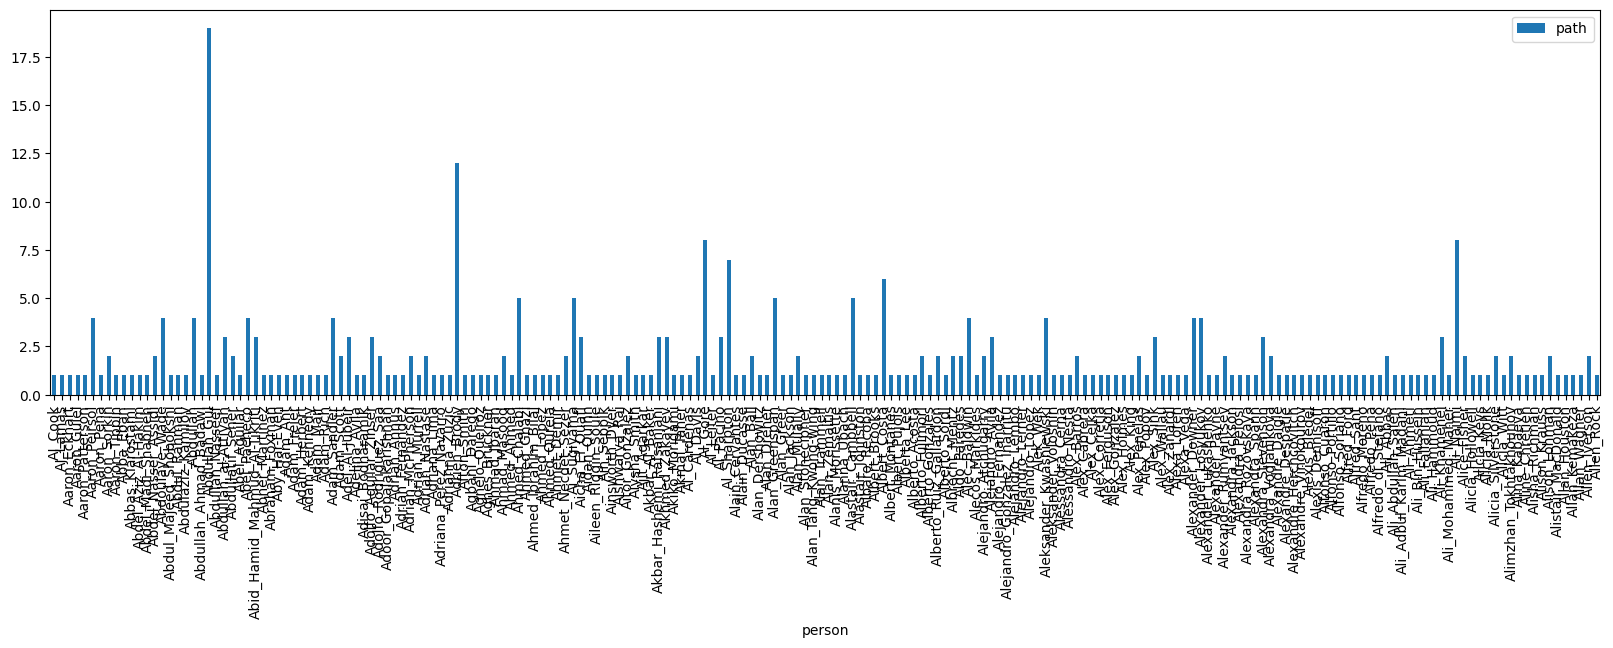

In [141]:
img_df.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

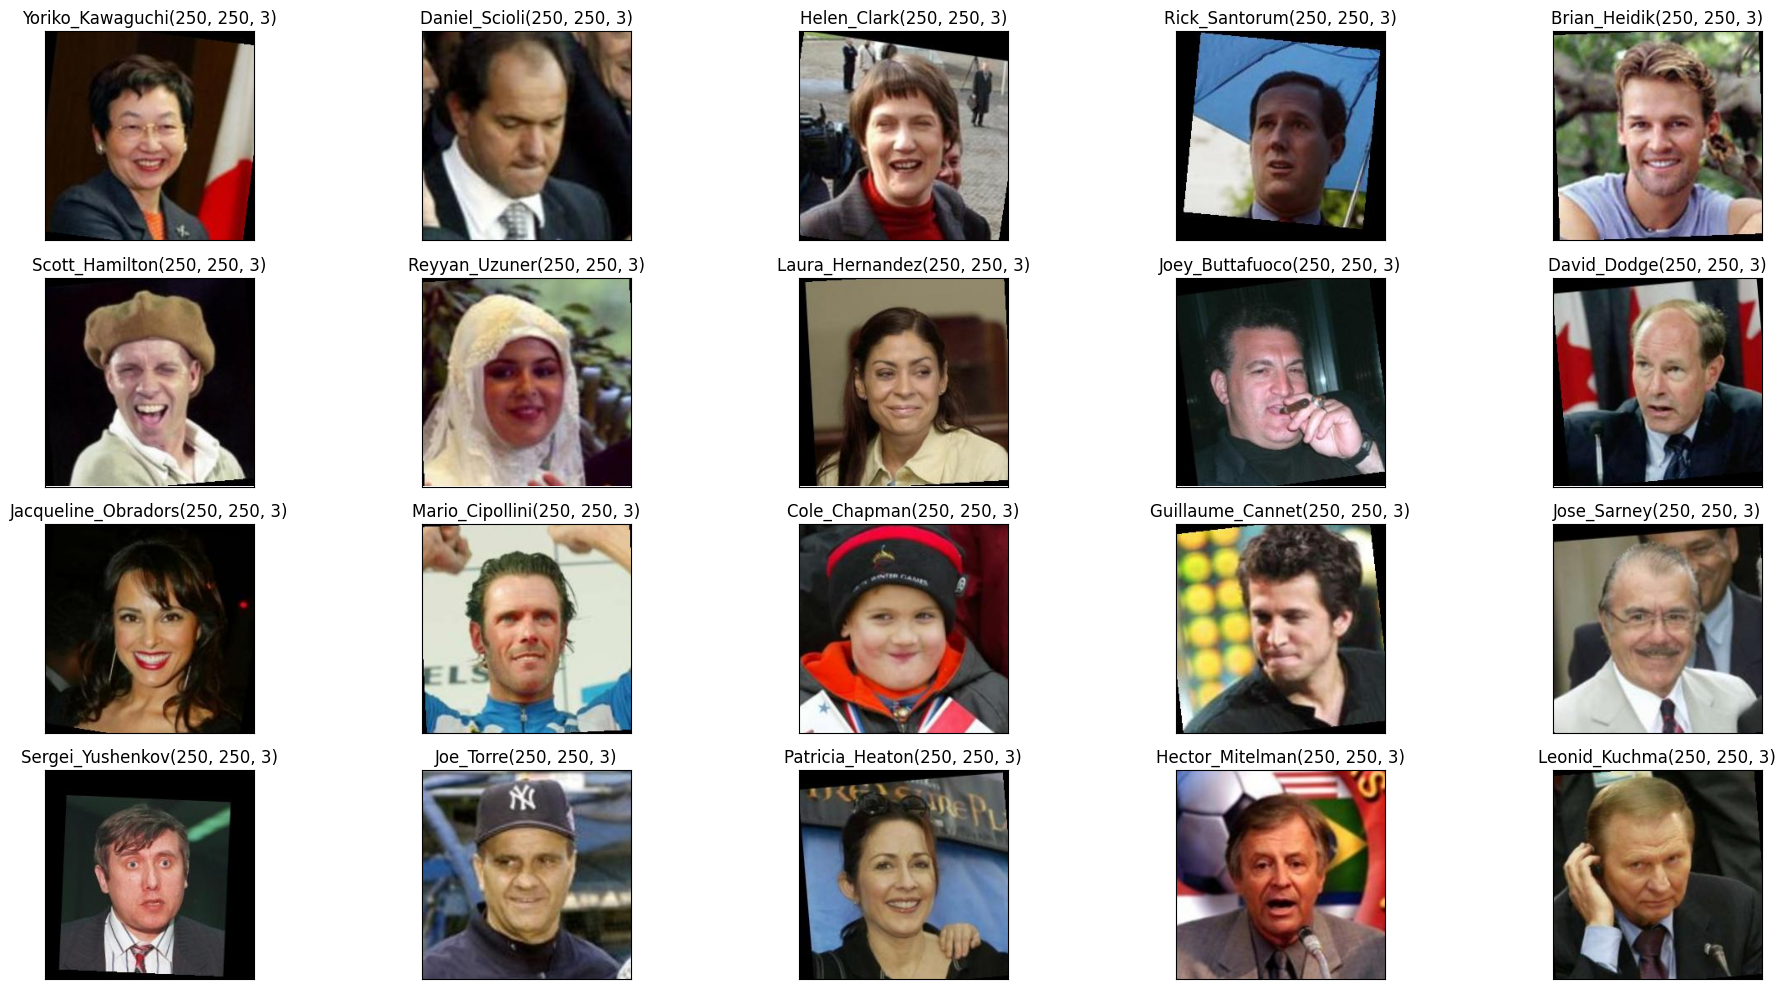

In [142]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(img_df))
    img = plt.imread(img_df.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(img_df.person.iloc[idx]+str(img.shape))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [143]:
# Custom Dataset for loading images
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        # image metdadata dataframe containing image path and attributes
        self.df = df        
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # idx is index in the image metadata dataframe
        img_path = self.df.loc[idx, "path"]  
        image = Image.open(img_path)               
        width, height = image.size
        # Ensure the crop does not go out of bounds
        left = 80
        right = width - 80
        upper = 80
        lower = height - 80        
        # Check if the crop dimensions are valid
        if right > left and lower > upper:
            image = image.crop((left, upper, right, lower))  # Crop the image
        else:
            raise ValueError("Invalid crop dimensions for the image.")
        if self.transform:
            image = self.transform(image)        
        return image

In [144]:
# Function to display input and output images
def display_images(input_img, output_img, epoch):    
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    axes[0].imshow(input_img)
    #axes[0].set_title(f"Input-Epoch {epoch}")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].imshow(output_img)
    #axes[1].set_title(f"Output-Epoch {epoch}")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    plt.show()

In [145]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(-1, *self.shape)

In [146]:
# split img_df into train and test
if Config.SUBSET_FRACTION is not None:
    img_df = img_df.sample(frac=Config.SUBSET_FRACTION, random_state=42).reset_index(drop=True)
train_df, val_df = train_test_split(img_df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [154]:
# transform = transforms.Compose([
#             transforms.Resize((45, 45)),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#             transforms.ToTensor()           
#         ])
# img_dataset = ImageDataset(df=img_df, transform=transform)
# img_dataset[0].shape

torch.Size([3, 45, 45])

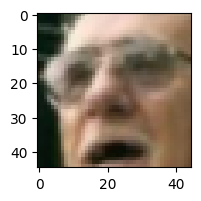

In [152]:
# plt.figure(figsize=(2, 2))
# plt.imshow(img_dataset[2].permute(1, 2, 0).cpu().detach().numpy())
# plt.show()

In [ ]:
class AutoencoderDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(Config.INPUT_IMAGE_SIZE),
            transforms.Normalize(mean=Config.TRAIN_IMG_MEAN, std=Config.TRAIN_IMG_STD),
            transforms.ToTensor()
        ])

    def setup(self, stage=None):
        self.train_dataset = ImageDataset(df=self.train_df, transform=self.transform)
        self.val_dataset = ImageDataset(df=self.val_df, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=Config.NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=Config.NUM_WORKERS)

In [ ]:
class DisplayImagesCallback(Callback):
    def on_validation_epoch_end(self, trainer, pl_module):                
        print(f"epoch = {trainer.current_epoch}",              
              f"val_loss = {trainer.callback_metrics['val_loss']}, "
              f"val_mse = {trainer.callback_metrics['val_mse']}, "
              f"cur_lr = {trainer.callback_metrics['cur_lr']}, "                        
        )
        # Get a batch of validation images
        val_imgs = next(iter(trainer.datamodule.val_dataloader()))  # Get the first batch
        inputs = val_imgs.to(pl_module.device)  # Move the input images to the appropriate device
        outputs = pl_module(inputs)  # Get the model's output for the input images
        
        # Prepare the first input and output image for display
        val_img = inputs[0].permute(1, 2, 0).cpu().detach().numpy()
        output_img = outputs[0].permute(1, 2, 0).cpu().detach().numpy()
        display_images(val_img, output_img, trainer.current_epoch + 1)  # Display the images        

In [ ]:
# Simple CNN Autoencoder
class ConvAutoencoderNetwork(nn.Module):
    def __init__(self):
        super(ConvAutoencoderNetwork, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # (64, 125, 125)-(64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (128, 63, 63)-(128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),# (256, 32, 32) - (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),# (512, 16, 16) - (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(512*4*4, 128)  # bottleneck
        )
        # Decoder
        self.decoder = nn.Sequential(
            # Input shape: (128,) from bottleneck layer
            nn.Linear(128, 512*4*4),  # reshape to (512, 16, 16)-(512, 4, 4)            
            nn.ReLU(True),
            Reshape((512, 4, 4)),
            # For transposed convolution:  n_out = (n_in-1)*stride - 2*padding + kernel_size + output_padding
            # n_out = (16-1)*2 - 2*1 + 3 + 1 = 32
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # (256, 32, 32)(256,8,8)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # n_out = (32-1)*2 - 2*1 + 3 + 0 = 63
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # (128, 63, 63)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # n_out = (63-1)*2 - 2*1 + 3 + 0 = 125
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 125, 125)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # n_out = (125-1)*2 - 2*1 + 3 + 1 = 250
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),    # (3, 250, 250)
            nn.Sigmoid()  # Use sigmoid to bring output values between [0, 1]
        )                

    def forward(self, x):
        x = self.encoder(x)
        # print(f"after encoding x.shape = {x.shape}")
        x = self.decoder(x)
        # print(f"after decoding x.shape = {x.shape}")
        return x

In [ ]:
class ConvAutoencoder(pl.LightningModule):
    def __init__(self, config, scheduler_config):
        super(ConvAutoencoder, self).__init__()
        self.config = config
        self.scheduler_config = scheduler_config
        self.network = ConvAutoencoderNetwork()                

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        inputs = batch
        outputs = self(inputs)
        loss = F.mse_loss(outputs, inputs)
        self.log('train_loss', loss, on_epoch=True, logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs = batch
        outputs = self(inputs)
        loss = F.mse_loss(outputs, inputs)
        mse = F.mse_loss(outputs, inputs)
        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log('val_loss', loss, on_epoch=True, logger=True, prog_bar=True)
        self.log('val_mse', mse, on_epoch=True, logger=True, prog_bar=True)
        self.log('cur_lr', current_lr, prog_bar=True, on_epoch=True, logger=True)
        return {'val_loss': loss, 'inputs': inputs, 'outputs': outputs}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.scheduler_config.MAX_LR)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, 
            step_size=self.scheduler_config.STEP_SIZE, 
            gamma=self.scheduler_config.GAMMA
        )
        return [optimizer], [scheduler]

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
# Main training code
try:    
    data_module = AutoencoderDataModule(train_df, val_df, Config.BATCH_SIZE)    
    model = ConvAutoencoder(Config, SchedulerConfig)
    wandb_logger = None
    if WandbConfig.USE_WANDB:
        wandb_logger = WandbLogger(project=WandbConfig.WANDB_PROJECT, name=WandbConfig.WANDB_RUN_NAME)    
        
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=Config.EARLY_STOPPING_PATIENCE,
        mode='min'
    )    
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='checkpoints',
        filename='autoencoder-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        mode='min'
    )    
    trainer = pl.Trainer(
        max_epochs=Config.NUM_EPOCHS,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        logger=wandb_logger,
        enable_model_summary=True,
        precision=Config.PRECISION,
        enable_progress_bar=True,
        log_every_n_steps=Config.LOG_EVERY_N_STEPS,
        callbacks=[DisplayImagesCallback(), early_stop_callback, checkpoint_callback]
    )    
    trainer.fit(model, data_module)
except KeyboardInterrupt as e:
    wandb.finish(exit_code=-1, quiet=True)
    print("Marked the wandb run as failed")
finally:    
    wandb.finish()

In [ ]:
# sample some random latent vectors and decode them
latent_vectors = torch.randn(10, 128)
decoded_images = model.network.decoder(latent_vectors)
# display the original and decoded images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(decoded_images[i].permute(1, 2, 0).cpu().detach().numpy())
    ax.axis('off')
plt.show()


In [13]:
# def train_model(model, train_loader, valid_loader, optimizer, scheduler, criterion, eval_metric, device, epochs):
#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0.0
#         for data in train_loader:
#             #print(f"input.shape = {data.shape}")
#             inputs = data.to(device)
#             outputs = model(inputs)
#             #print(f"output.shape = {outputs.shape}")
#             loss = criterion(outputs, inputs)        
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
        
#         model.eval()
#         valid_loss = 0
#         valid_metric = 0
#         with torch.no_grad():
#             for data in valid_loader:
#                 inputs = data.to(device)  # Select a single image
#                 outputs = model(inputs)
#                 #display_images(input_img[0], output_img[0], epoch+1)
#                 valid_loss += criterion(outputs, inputs).item()                
#                 valid_metric += eval_metric(outputs, inputs).item()
        
#         # Print epoch results including the current learning rate and evaluation metric
#         print(f'Epoch {epoch+1}/{epochs}, '
#               f'Training Loss: {train_loss/len(train_loader):.6f}, '
#               f'Validation Loss: {valid_loss/len(valid_loader):.6f}, '
#               f'Validation Metric: {valid_metric/len(valid_loader):.6f}, '
#               f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
#         # Log metrics to W&B
#         wandb.log({
#             "pt_train_loss": train_loss/len(train_loader),
#             "pt_val_loss": valid_loss/len(valid_loader),
#             "pt_val_mse": valid_metric/len(valid_loader),
#             "pt_cur_lr": scheduler.get_last_lr()[0],
#         }, step=epoch)
        
#         val_img = inputs[0].permute(1, 2, 0).cpu().detach().numpy()
#         output_img = outputs[0].permute(1, 2, 0).cpu().detach().numpy()
#         display_images(val_img, output_img, epoch+1)
#         # Step the scheduler
#         scheduler.step()                

In [14]:
# def mse_metric(predictions, targets):
#     return torch.mean((predictions - targets) ** 2)

In [ ]:
# try:
#     # Data loading and preprocessing
#     transform = transforms.Compose([
#         transforms.Resize((250, 250)),
#         transforms.ToTensor()
#     ])

#     ds_train = ImageDataset(df=train_df, transform=transform)
#     ds_val = ImageDataset(df=val_df, transform=transform)
#     dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True)
#     dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE)

#     # Initialize model, loss function, and optimizer
#     pt_model = ConvAutoencoder().to(Config.DEVICE)
#     criterion = nn.MSELoss()  # Mean Squared Error loss
#     optimizer = optim.Adam(pt_model.parameters(), lr=SchedulerConfig.MAX_LR)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=SchedulerConfig.STEP_SIZE, gamma=SchedulerConfig.GAMMA)
#     eval_metric = mse_metric

#     train_model(pt_model, dl_train, dl_val, optimizer, 
#                 scheduler=scheduler,
#                 criterion=criterion, 
#                 device=Config.DEVICE, 
#                 epochs=Config.NUM_EPOCHS,
#                 eval_metric=eval_metric)
# except KeyboardInterrupt as e:
#     wandb.finish(exit_code=-1, quiet=True)
#     print("Marked the wandb run as failed")
# finally:    
#     wandb.finish()

In [ ]:
# # sample some random latent vectors and decode them
# latent_vectors = torch.randn(10, 128)
# decoded_images = pt_model.decoder(latent_vectors)
# # display the original and decoded images
# fig, axes = plt.subplots(2, 5, figsize=(10, 4))
# for i, ax in enumerate(axes.flat):
#     ax.imshow(decoded_images[i].permute(1, 2, 0).cpu().detach().numpy())
#     ax.axis('off')
# plt.show()
